<a href="https://colab.research.google.com/github/Desi385/nbdev-hello-world/blob/main/Yolo_Image_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing required libraries...

--- Starting Product Detection Script ---


Saving Image_annotate.jpg to Image_annotate (3).jpg
Uploaded file: Image_annotate (3).jpg


100%|██████████| 49.7M/49.7M [00:01<00:00, 47.4MB/s]


Loaded YOLO model: yolov8m.pt

0: 480x640 1 handbag, 9 bottles, 1 spoon, 1 book, 1221.6ms
Speed: 5.1ms preprocess, 1221.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

SUPERMARKET PRODUCT DETECTION ANALYSIS

Image: /content/Image_annotate (3).jpg
Method Used: YOLO
Analysis Time: 2025-07-22 08:43:38
Inference Time: 1.852 seconds

TOTAL PRODUCTS DETECTED: 12

PRODUCT COUNTS BY CATEGORY:
  • bottle: 9
  • spoon: 1
  • handbag: 1
  • book: 1

PRODUCT SEQUENCES (Reading Order):
  • bottle (9 items):
    bottle_1(350,203,conf:0.08) -> bottle_2(1079,319,conf:0.12) -> bottle_3(305,321,conf:0.11) -> bottle_4(333,322,conf:0.06) -> bottle_5(363,322,conf:0.06) -> bottle_6(396,324,conf:0.09) -> bottle_7(420,324,conf:0.11) -> bottle_8(325,428,conf:0.08) -> bottle_9(381,430,conf:0.10)
  • spoon (1 items):
    spoon_1(807,770,conf:0.09)
  • handbag (1 items):
    handbag_1(887,293,conf:0.08)
  • book (1 items):
    book_1(1268,119,conf:0.06)

SHELF STRUCTURE ANALYSIS:
  • Detecte

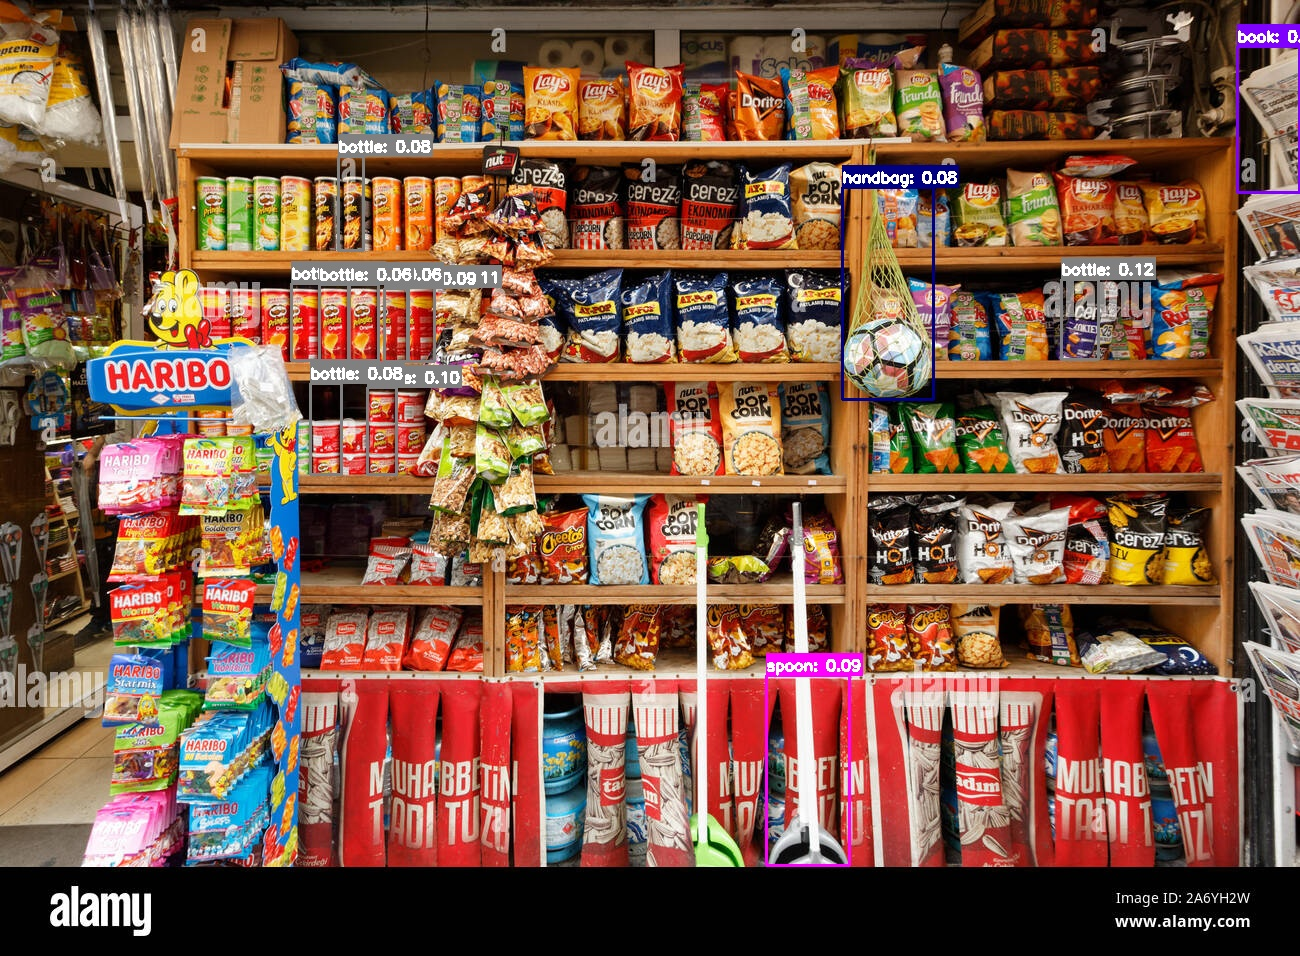


--- Script Finished ---


In [26]:
# -*- coding: utf-8 -*-
"""
# Supermarket Product Detection and Analysis in Google Colab

This notebook provides a self-contained script for product detection, annotation,
sequencing, and counting in supermarket images using YOLOv8, designed for Google Colab.

**Instructions:**
1.  Run all cells in this notebook.
2.  Upload your image file when prompted, or modify the `image_path` variable.
3.  Review the printed analysis and the annotated image output.

**Note:** For robust and accurate detection on your specific product types,
fine-tuning a YOLOv8 model on a custom dataset is highly recommended.
"""

# 1. Install necessary libraries
print("Installing required libraries...")
!pip install ultralytics opencv-python matplotlib numpy

# Import necessary libraries
import cv2
import numpy as np
import json
import os
from pathlib import Path
from collections import defaultdict
import time
from google.colab.patches import cv2_imshow # For displaying images in Colab
from IPython.display import display, Javascript
from google.colab import files

try:
    from ultralytics import YOLO
    YOLO_AVAILABLE = True
except ImportError:
    YOLO_AVAILABLE = False
    print("Warning: ultralytics not available. Please ensure installation was successful.")

class SupermarketProductDetector:
    """
    Comprehensive product detector for supermarket images.
    """

    def __init__(self, model_name="yolov8m.pt", conf_threshold=0.05):
        """
        Initialize the detector.

        Args:
            model_name (str): YOLO model to use
            conf_threshold (float): Confidence threshold for detections
        """
        self.conf_threshold = conf_threshold
        self.model = None

        if YOLO_AVAILABLE:
            try:
                self.model = YOLO(model_name)
                print(f"Loaded YOLO model: {model_name}")
            except Exception as e:
                print(f"Error loading YOLO model: {e}. Falling back to template matching if YOLO fails.")
                self.model = None

        # Color palette for different classes
        self.colors = [
            (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
            (255, 0, 255), (0, 255, 255), (128, 0, 0), (0, 128, 0),
            (0, 0, 128), (128, 128, 0), (128, 0, 128), (0, 128, 128),
            (255, 128, 0), (255, 0, 128), (128, 255, 0), (0, 255, 128),
            (128, 0, 255), (0, 128, 255), (192, 192, 192), (128, 128, 128)
        ]

    def detect_products_yolo(self, image_path):
        """
        Detect products using YOLO model.

        Args:
            image_path (str): Path to input image

        Returns:
            tuple: (annotated_image, detections_list, analysis_dict)
        """
        if not self.model:
            return None, [], {}

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not load image from {image_path}")
            return None, [], {}

        # Run YOLO inference
        start_time = time.time()
        results = self.model(img, conf=self.conf_threshold)
        inference_time = time.time() - start_time

        # Process results
        detections = []
        annotated_img = img.copy()

        for r in results:
            if r.boxes is not None:
                boxes = r.boxes
                for i, box in enumerate(boxes):
                    # Extract box information
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    conf = float(box.conf[0])
                    cls_id = int(box.cls[0])
                    cls_name = self.model.names[cls_id]

                    # Calculate additional metrics
                    center_x = (x1 + x2) // 2
                    center_y = (y1 + y2) // 2
                    width = x2 - x1
                    height = y2 - y1
                    area = width * height

                    detection = {
                        'id': i,
                        'class_name': cls_name,
                        'class_id': cls_id,
                        'confidence': conf,
                        'bbox': [x1, y1, x2, y2],
                        'center': [center_x, center_y],
                        'dimensions': [width, height],
                        'area': area
                    }
                    detections.append(detection)

                    # Draw bounding box
                    color = self.colors[cls_id % len(self.colors)]
                    cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)

                    # Draw label
                    label = f"{cls_name}: {conf:.2f}"
                    label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                    cv2.rectangle(annotated_img, (x1, y1 - label_size[1] - 10),
                                 (x1 + label_size[0], y1), color, -1)
                    cv2.putText(annotated_img, label, (x1, y1 - 5),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        analysis = {
            'method': 'YOLO',
            'model': str(self.model.model_name) if hasattr(self.model, 'model_name') else 'yolov8m',
            'inference_time': inference_time,
            'total_detections': len(detections),
            'image_shape': img.shape
        }

        return annotated_img, detections, analysis

    def detect_products_template(self, image_path):
        """
        Detect products using template matching and contour detection.
        This is a fallback method when YOLO is not available or performs poorly.

        Args:
            image_path (str): Path to input image

        Returns:
            tuple: (annotated_image, detections_list, analysis_dict)
        """
        img = cv2.imread(image_path)
        if img is None:
            return None, [], {}

        start_time = time.time()

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Edge detection
        edges = cv2.Canny(blurred, 50, 150)

        # Morphological operations to connect edges
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        # Find contours
        contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detections = []
        annotated_img = img.copy()

        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)

            # Filter contours by area (adjust thresholds as needed)
            if 500 < area < 50000:
                # Get bounding rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Filter by aspect ratio (reasonable for products)
                aspect_ratio = w / h if h > 0 else 0
                if 0.2 < aspect_ratio < 5.0:
                    center_x = x + w // 2
                    center_y = y + h // 2

                    detection = {
                        'id': i,
                        'class_name': 'product',
                        'class_id': 0,
                        'confidence': min(0.8, area / 10000),  # Confidence based on area
                        'bbox': [x, y, x + w, y + h],
                        'center': [center_x, center_y],
                        'dimensions': [w, h],
                        'area': area
                    }
                    detections.append(detection)

                    # Draw bounding box
                    cv2.rectangle(annotated_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.putText(annotated_img, f"Object {i+1}", (x, y - 10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        inference_time = time.time() - start_time

        analysis = {
            'method': 'Template/Contour',
            'inference_time': inference_time,
            'total_detections': len(detections),
            'image_shape': img.shape
        }

        return annotated_img, detections, analysis

    def count_products(self, detections):
        """
        Count products by category.

        Args:
            detections (list): List of detection dictionaries

        Returns:
            dict: Product counts by class name
        """
        counts = defaultdict(int)
        for detection in detections:
            counts[detection['class_name']] += 1
        return dict(counts)

    def generate_sequences(self, detections):
        """
        Generate product sequences based on spatial arrangement.

        Args:
            detections (list): List of detection dictionaries

        Returns:
            dict: Sequences by class name
        """
        if not detections:
            return {}

        # Group detections by class
        class_groups = defaultdict(list)
        for detection in detections:
            class_groups[detection['class_name']].append(detection)

        sequences = {}
        for class_name, class_detections in class_groups.items():
            # Sort by y-coordinate first (top to bottom), then x-coordinate (left to right)
            sorted_detections = sorted(class_detections,
                                     key=lambda d: (d['center'][1], d['center'][0]))

            # Create sequence string
            sequence_parts = []
            for i, det in enumerate(sorted_detections):
                x, y = det['center']
                conf = det['confidence']
                sequence_parts.append(f"{class_name}_{i+1}({x},{y},conf:{conf:.2f})")

            sequences[class_name] = {
                'count': len(sorted_detections),
                'sequence': ' -> '.join(sequence_parts),
                'positions': [det['center'] for det in sorted_detections]
            }

        return sequences

    def analyze_shelf_structure(self, image_path):
        """
        Analyze shelf structure in the image.

        Args:
            image_path (str): Path to input image

        Returns:
            dict: Shelf analysis results
        """
        img = cv2.imread(image_path)
        if img is None:
            return {}

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect horizontal lines (potential shelves)
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
        horizontal_lines = cv2.morphologyEx(gray, cv2.MORPH_OPEN, horizontal_kernel)

        # Find contours of horizontal lines
        contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        shelf_lines = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > img.shape[1] * 0.2:  # Line should be reasonably long
                shelf_lines.append({
                    'y_position': y,
                    'x_start': x,
                    'x_end': x + w,
                    'length': w
                })

        # Sort by y-position
        shelf_lines.sort(key=lambda x: x['y_position'])

        # Estimate shelf heights
        shelf_heights = []
        if len(shelf_lines) > 1:
            for i in range(len(shelf_lines) - 1):
                height = shelf_lines[i + 1]['y_position'] - shelf_lines[i]['y_position']
                shelf_heights.append(height)

        return {
            'detected_shelves': len(shelf_lines),
            'shelf_positions': [line['y_position'] for line in shelf_lines],
            'average_shelf_height': int(np.mean(shelf_heights)) if shelf_heights else None,
            'image_dimensions': img.shape
        }

    def create_comprehensive_report(self, image_path, output_dir="/content/"):
        """
        Create a comprehensive analysis report.

        Args:
            image_path (str): Path to input image
            output_dir (str): Directory to save outputs

        Returns:
            dict: Complete analysis report
        """
        os.makedirs(output_dir, exist_ok=True)

        # Try YOLO detection first
        yolo_img, yolo_detections, yolo_analysis = self.detect_products_yolo(image_path)

        # Try template matching as fallback
        template_img, template_detections, template_analysis = self.detect_products_template(image_path)

        # Choose best method based on number of detections
        if len(yolo_detections) > 0:
            best_img, best_detections, best_analysis = yolo_img, yolo_detections, yolo_analysis
            method_used = "YOLO"
        else:
            best_img, best_detections, best_analysis = template_img, template_detections, template_analysis
            method_used = "Template/Contour"

        # Generate analysis
        product_counts = self.count_products(best_detections)
        sequences = self.generate_sequences(best_detections)
        shelf_analysis = self.analyze_shelf_structure(image_path)

        # Create comprehensive report
        report = {
            'image_info': {
                'path': image_path,
                'method_used': method_used,
                'analysis_timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
            },
            'detection_summary': {
                'total_products': len(best_detections),
                'product_counts': product_counts,
                'inference_time': best_analysis.get('inference_time', 0)
            },
            'spatial_analysis': {
                'sequences': sequences,
                'shelf_structure': shelf_analysis
            },
            'detailed_detections': best_detections,
            'method_comparison': {
                'yolo': {
                    'available': YOLO_AVAILABLE,
                    'detections': len(yolo_detections),
                    'time': yolo_analysis.get('inference_time', 0)
                },
                'template': {
                    'detections': len(template_detections),
                    'time': template_analysis.get('inference_time', 0)
                }
            }
        }

        # Save annotated image
        if best_img is not None:
            base_name = Path(image_path).stem
            output_image_path = os.path.join(output_dir, f"{base_name}_annotated.jpg")
            cv2.imwrite(output_image_path, best_img)
            report['output_files'] = {'annotated_image': output_image_path}

        # Save JSON report
        json_path = os.path.join(output_dir, f"{Path(image_path).stem}_analysis.json")
        with open(json_path, 'w') as f:
            json.dump(report, f, indent=2)

        if 'output_files' not in report:
            report['output_files'] = {}
        report['output_files']['json_report'] = json_path

        return report

def print_report(report):
    """
    Print a formatted analysis report.
    """
    print("\n" + "="*60)
    print("SUPERMARKET PRODUCT DETECTION ANALYSIS")
    print("="*60)

    # Basic info
    print(f"\nImage: {report['image_info']['path']}")
    print(f"Method Used: {report['image_info']['method_used']}")
    print(f"Analysis Time: {report['image_info']['analysis_timestamp']}")
    print(f"Inference Time: {report['detection_summary']['inference_time']:.3f} seconds")

    # Detection summary
    print(f"\nTOTAL PRODUCTS DETECTED: {report['detection_summary']['total_products']}")

    # Product counts
    print("\nPRODUCT COUNTS BY CATEGORY:")
    for product, count in report['detection_summary']['product_counts'].items():
        print(f"  • {product}: {count}")

    # Sequences
    print("\nPRODUCT SEQUENCES (Reading Order):")
    for product, seq_info in report['spatial_analysis']['sequences'].items():
        print(f"  • {product} ({seq_info['count']} items):")
        print(f"    {seq_info['sequence']}")

    # Shelf analysis
    shelf_info = report['spatial_analysis']['shelf_structure']
    print(f"\nSHELF STRUCTURE ANALYSIS:")
    print(f"  • Detected shelves: {shelf_info['detected_shelves']}")
    if shelf_info['average_shelf_height']:
        print(f"  • Average shelf height: {shelf_info['average_shelf_height']}px")

    # Method comparison
    print(f"\nMETHOD COMPARISON:")
    methods = report['method_comparison']
    print(f"  • YOLO: {methods['yolo']['detections']} detections ({methods['yolo']['time']:.3f}s)")
    print(f"  • Template: {methods['template']['detections']} detections ({methods['template']['time']:.3f}s)")

    # Output files
    if 'output_files' in report:
        print(f"\nOUTPUT FILES:")
        for file_type, path in report['output_files'].items():
            print(f"  • {file_type}: {path}")

    print("\n" + "="*60)

# --- Main execution for Google Colab ---
if __name__ == "__main__":
    print("\n--- Starting Product Detection Script ---")

    # 2. Upload image file
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
    else:
        image_filename = list(uploaded.keys())[0]
        image_path = f"/content/{image_filename}"
        print(f"Uploaded file: {image_filename}")

        # 3. Initialize and run detector
        detector = SupermarketProductDetector(conf_threshold=0.05) # Adjust conf_threshold as needed
        report = detector.create_comprehensive_report(image_path)

        # 4. Print report and display annotated image
        print_report(report)

        if 'output_files' in report and 'annotated_image' in report['output_files']:
            print("\nDisplaying annotated image:")
            annotated_img_path = report['output_files']['annotated_image']
            annotated_img = cv2.imread(annotated_img_path)
            if annotated_img is not None:
                cv2_imshow(annotated_img)
            else:
                print(f"Error: Could not load annotated image from {annotated_img_path}")

        print("\n--- Script Finished ---")

